In [1]:
from data_process import *

train_loader, test_loader = load_mnist()


torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


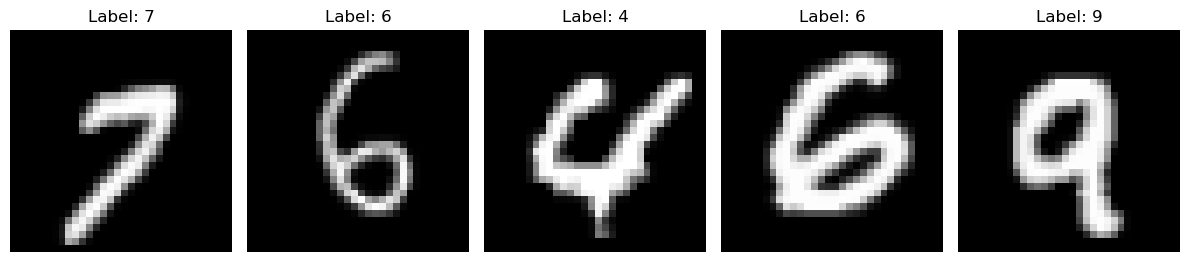

In [4]:
import matplotlib.pyplot as plt

# 1. Get one batch
images, labels = next(iter(train_loader))  # train_loader from your previous code

# 2. Plot the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    print(images[i].shape)
    img = images[i].squeeze(0)           # from (1,28,28) → (28,28)
    axes[i].imshow(img, cmap='gray')     # display as grayscale
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
from model import *

device = 'cuda'
model = SimpleUnet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  62248577


In [4]:
import torch
import torch.nn.functional as F

T = 500
start = 0.0001
end = 0.05
device = 'cuda'
IMG_SIZE = 32
BATCH_SIZE = 512

betas = torch.linspace(start, end, T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis = 0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 



def show_images(img_name, dataset, num_samples=20, cols=5, save = False):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(dataset):
        img = img.detach().to('cpu')
        if i == num_samples:
            break
        img = convert_to_image(img)
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)
    
    if (save == True):
        name = 'output' + str(img_name) + '.png'
        plt.savefig('/home/longvv/generative_model/diffusion-real/result' + name)
    plt.show()

@torch.no_grad()
def sample_plot_image(img_name):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, img_size, img_size), device=device)
    img_set = []
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            img_set.append(img.squeeze(dim = 0))
            
    show_images(img_name, img_set, save = True)



model_path = '/home/dominhnhat/Classroom/generative_model/trained_model/diffusion_mnist.pth'

from torch.optim import AdamW
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = AdamW(model.parameters(), lr=0.001)
epochs = 30 # Try more!
for epoch in range(epochs):

    model.train()
    for step, (X , y) in enumerate(train_loader):

        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        t = torch.randint(0, T, (X.shape[0],), device=device).long()
        loss = get_loss(model, X, t)
        loss.backward()
        optimizer.step()

        if step % 30 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            if (step == len(train_loader) and (epoch + 1) % 5 == 0):
                sample_plot_image((epoch + 1)//5)
    
    model.eval()
    total_loss = 0
    for step, (X, y) in enumerate(test_loader):
        t = torch.randint(0, T, (X.shape[0],), device=device).long()
        loss = get_loss(model, X, t)
        total_loss += loss.item()
    
    print(f"Test Loss : {total_loss/len(test_loader)}")
    print('-' * 30)

torch.save(model.state_dict(), model_path)


/home/longvv/anaconda3/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/longvv/anaconda3/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 | step 000 Loss: 1.0406975746154785 
Epoch 0 | step 050 Loss: 0.08050055801868439 
Epoch 0 | step 100 Loss: 0.04833803325891495 


/home/longvv/anaconda3/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test Loss : 0.050387106649577615
------------------------------
Epoch 1 | step 000 Loss: 0.04599813371896744 
Epoch 1 | step 050 Loss: 0.04368111863732338 
Epoch 1 | step 100 Loss: 0.03586839139461517 
Test Loss : 0.044375492818653585
------------------------------
Epoch 2 | step 000 Loss: 0.03511230647563934 
Epoch 2 | step 050 Loss: 0.03560757637023926 


KeyboardInterrupt: 